[source](https://github.com/zjost/blog_code/blob/master/gcn_numpy/gcn_from_scratch.ipynb)

In [1]:
import numpy as np

from scipy.linalg import sqrtm
from scipy.special import softmax

import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

import matplotlib.pyplot as plt

In [2]:
def draw_kkl(nx_G,
            label_map,
            node_color,
            pos=None,
            **kwargs):
    fig ,ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))
        
    nx.draw(
        nx_G,
        pos,
        with_labels=label_map is not None,
        labels=label_map,
        node_color=node_color,
        ax=ax,
        **kwargs
    )

In [3]:
g = nx.karate_club_graph()

In [4]:
g.number_of_nodes(), g.number_of_edges()

(34, 78)

In [5]:
communities = greedy_modularity_communities(g)

In [6]:
colors = np.zeros(g.number_of_nodes())

for i, com in enumerate(communities):
    colors[list(com)] = i
    
n_classes = np.unique(colors).shape[0]
labels = np.eye(n_classes)[colors.astype(int)]

In [7]:
club_labels = nx.get_node_attributes(g, 'club')

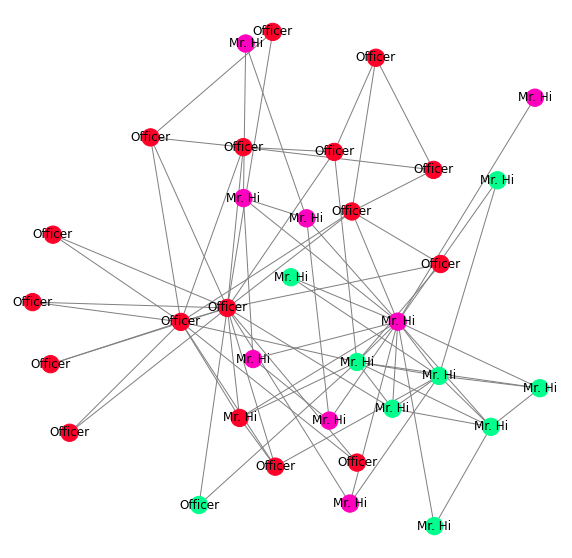

In [8]:
_ = draw_kkl(g, club_labels, colors, cmap='gist_rainbow', edge_color='gray')

In [9]:
A = nx.to_numpy_matrix(g)
A

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

In [10]:
A_mod = A + np.eye(g.number_of_nodes())

D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis=1)).flatten())

D_mod_invroot = np.linalg.inv(sqrtm(D_mod))
A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

In [11]:
X = np.eye(g.number_of_nodes())

In [12]:
def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))

## xent ?
def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]

def norm_diff(dW, dW_approx):
    return np.linalg.norm(dW - dW_approx) / (np.linalg.norm(dW) + np.linalg.norm(dW_approx))

In [13]:
class GradDescentOptim():
    def __init__(self, lr, wd):
        self.lr = lr
        self.wd = wd
        self._y_pred = None
        self._y_true = None
        self._out = None
        self.bs = None
        self.train_nodes = None
        
    def __call__(self, y_pred, y_true, train_nodes=None):
        self.y_pred = y_pred
        self.y_true = y_true
        
        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes
            
        self.bs = self.train_nodes.shape[0]
        
    @property
    def out(self):
        return self._out
    
    @out.setter
    def out(self, y):
        self._out = y

In [14]:
class GCNLayer():
    def __init__(self, n_inputs, n_outputs, activation=None, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = activation
        self.name = name
        
    def __repr__(self):
        return f"GCN: {'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
    
    def forward(self, A, X, W=None):
        self._A = A
        self._X = (A @ X).T
        
        if W is None:
            W = self.W
            
        H = W @ self._X
        if self.activation is not None:
            H = self.activation(H)
        self._H = H
        return self._H.T
    
    def backward(self, optim, update=True):
        dtanh = 1 - np.asarray(self._H.T)**2
        d2 = np.multiply(optim.out, dtanh)
        
        self.grad = self._A @ d2 @ self.W
        optim.out = self.grad
        
        dW = np.asarray(d2.T @ self._X.T) / optim.bs
        dW_wd = self.W * optim.wd / optim.bs
        
        if update:
            self.W -= (dW + dW_wd) * optim.lr
            
        return dW + dW_wd

In [15]:
class SoftmaxLayer():
    def __init__(self, n_inputs, n_outputs, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.b = np.zeros((self.n_outputs, 1))
        self.name = name
        self._X = None
        
    def __repr__(self):
        return f"Softmax: {'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
    
    def shift(self, proj):
        shiftx = proj - np.max(proj, axis=0, keepdims=True)
        exps = np.exp(shiftx)
        return exps / np.sum(exps, axis=0, keepdims=True)
    
    def forward(self, X, W=None, b=None):
        self._X = X.T
        if W is None:
            W = self.W
        if b is None:
            b = self.b
        
        proj = np.asarray(W @ self._X) + b
        return self.shift(proj).T
        
    def backward(self, optim, update=True):
        train_mask = np.zeros(optim.y_pred.shape[0])
        train_mask[optim.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))
        
        d1 = np.asarray((optim.y_pred - optim.y_true))
        d1 = np.multiply(d1, train_mask)
        
        self.grad = d1 @ self.W
        optim.out = self.grad
        
        dW = (d1.T @ self._X.T) / optim.bs
        db = d1.T.sum(axis=1, keepdims=True) / optim.bs
        
        dW_wd = self.W * optim.wd / optim.bs
        
        if update:
            self.W -= (dW + dW_wd) * optim.lr
            self.b -= db.reshape(self.b.shape) * optim.lr
            
        return dW + dW_wd, db.reshape(self.b.shape)   

In [16]:
gcn1 = GCNLayer(g.number_of_nodes(), 2, activation=np.tanh, name='1')
sm1 = SoftmaxLayer(2, n_classes, 'SM')
opt = GradDescentOptim(lr=0, wd=1.)

In [17]:
gcn1_out = gcn1.forward(A_hat, X)
opt(sm1.forward(gcn1_out), labels)

In [18]:
def get_grads(inputs, layer, argname, labels, eps=1e-4, wd=0):
    cp = getattr(layer, argname).copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_params = cp_flat.shape[0]
    
    for i, theta in enumerate(cp_flat):
        # print(f"Parm {argname}_{i}")
        theta_cp = theta
        
        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predp = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jp = xent(predp, labels).mean() + wd_term
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predm = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jm = xent(predm, labels).mean() + wd_term
        
        # grad
        grads[i] = ((Jp - Jm) / (2*eps))
        
        # Back to normal
        cp_flat[i] = theta
        
    return grads.reshape(cp.shape)

In [19]:
dW_approx = get_grads((gcn1_out,), sm1, 'W', labels, eps=1e-4, wd=opt.wd)
db_approx = get_grads((gcn1_out,), sm1, 'W', labels, eps=1e-4, wd=opt.wd)

In [20]:
dW, db = sm1.backward(opt, update=False)

In [21]:
assert norm_diff(dW, dW_approx) < 1e-7
assert norm_diff(db, db_approx) < 10

In [22]:
def get_gcn_input_grads(A_hat, X, gcn, sm_layer, labels, eps=1e-4):
    cp = X.copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i , x in enumerate(cp_flat):
        x_cp = x
        
        # J(theta + eps)
        cp_flat[i] = x + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(A_hat, cp_tmp))
        Jp = xent(pred, labels).mean()
        
        # J(theta - eps)
        cp_flat[i] = x - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(A_hat, cp_tmp))
        Jm = xent(pred, labels).mean()
        
        # grad
        grads[i] = ((Jp - Jm) / (2*eps))
        
        # Back to normal
        cp_flat[i] = x
        
    return grads.reshape(cp.shape)

In [23]:
dX_approx = get_gcn_input_grads(A_hat, X, gcn1, sm1, labels, eps=1e-4)

In [24]:
class GCNNetwork():
    def __init__(self, n_inputs, n_outputs, n_layers, hidden_sizes, activation, seed=0):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        
        np.random.seed(seed)
        
        self.layers = list()
        # input layer
        gcn_in = GCNLayer(n_inputs, hidden_sizes[0], activation, name='in')
        self.layers.append(gcn_in)
        
        # hidden layers
        for layer in range(n_layers):
            gcn = GCNLayer(self.layers[-1].W.shape[0], hidden_sizes[layer], activation, name=f'h{layer}')
            self.layers.append(gcn)
        
        sm_out = SoftmaxLayer(hidden_sizes[-1], n_outputs, name='sm')
        self.layers.append(sm_out)
        
    def __repr__(self):
        return '\n'.join([str(l) for l in self.layers])
    
    def embedding(self, A, X):
        H = X
        for layer in self.layers[:-1]:
            H = layer.forward(A, H)
        return np.asarray(H)

    def forward(self, A, X):
        H = self.embedding(A, X)
        p = self.layers[-1].forward(H)
        
        return np.asarray(p)    

In [25]:
gcn_model = GCNNetwork(
    n_inputs=g.number_of_nodes(),
    n_outputs=n_classes,
    n_layers=2,
    hidden_sizes=[16,2],
    activation=np.tanh,
    seed=100,
)

In [26]:
gcn_model

GCN: _in (34, 16)
GCN: _h0 (16, 16)
GCN: _h1 (16, 2)
Softmax: _sm (2, 3)

In [27]:
y_pred = gcn_model.forward(A_hat, X)
embed = gcn_model.embedding(A_hat, X)
xent(y_pred, labels).mean()

1.0759636138197173

In [28]:
train_nodes = np.array([0, 1, 8])
test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])
opt2 = GradDescentOptim(lr=2e-2, wd=2.5e-2)

In [34]:
embeds = list()
accs = list()
train_losses = list()
test_losses = list()

loss_min = 1e6
es_iters = 0
es_steps = 50

for epoch in range(15000):
    
    y_pred = gcn_model.forward(A_hat, X)
    
    opt2(y_pred, labels, train_nodes)
    
    for layer in reversed(gcn_model.layers):
        layer.backward(opt2, update=True)
    
    embeds.append(gcn_model.embedding(A_hat, X))
    acc = (np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))[
        [i for i in range(labels.shape[0]) if i not in train_nodes]
    ]
    accs.append(acc.mean())
    
    loss = xent(y_pred, labels)
    loss_train = loss[train_nodes].mean()
    loss_test = loss[test_nodes].mean()
    
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    if loss_test < loss_min:
        loss_min = loss_test
        es_iters = 0
    else:
        es_iters += 1
        
    if es_iters > es_steps:
        print('Early Stopping!')
        break
        
    if epoch % 100 == 0 :
        print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")
        
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

Epoch: 1, Train Loss: 1.086, Test Loss: 1.074
Epoch: 101, Train Loss: 1.048, Test Loss: 1.043
Epoch: 201, Train Loss: 1.002, Test Loss: 0.997
Epoch: 301, Train Loss: 0.939, Test Loss: 0.930
Epoch: 401, Train Loss: 0.856, Test Loss: 0.836
Epoch: 501, Train Loss: 0.753, Test Loss: 0.723
Epoch: 601, Train Loss: 0.639, Test Loss: 0.614
Epoch: 701, Train Loss: 0.533, Test Loss: 0.530
Epoch: 801, Train Loss: 0.443, Test Loss: 0.474
Epoch: 901, Train Loss: 0.368, Test Loss: 0.435
Epoch: 1001, Train Loss: 0.306, Test Loss: 0.408
Epoch: 1101, Train Loss: 0.254, Test Loss: 0.388
Epoch: 1201, Train Loss: 0.214, Test Loss: 0.374
Epoch: 1301, Train Loss: 0.183, Test Loss: 0.365
Epoch: 1401, Train Loss: 0.159, Test Loss: 0.360
Epoch: 1501, Train Loss: 0.141, Test Loss: 0.357
Epoch: 1601, Train Loss: 0.127, Test Loss: 0.355
Epoch: 1701, Train Loss: 0.116, Test Loss: 0.354
Epoch: 1801, Train Loss: 0.107, Test Loss: 0.353
Epoch: 1901, Train Loss: 0.100, Test Loss: 0.353
Epoch: 2001, Train Loss: 0.094, 

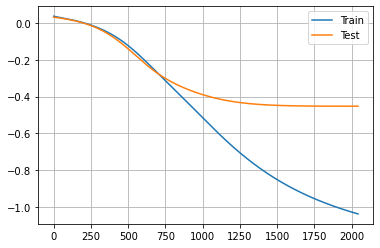

In [35]:
fig, ax = plt.subplots()
ax.plot(np.log10(train_losses), label='Train')
ax.plot(np.log10(test_losses), label='Test')
ax.legend()
ax.grid()

In [37]:
accs[-1]

0.8709677419354839